In [225]:
from scipy.io import wavfile
import scipy.signal as ss
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from IPython.display import Audio
import librosa
from librosa import display

In [226]:
def espectral_single(signal, fs, **kwargs):
    """Transforma o sinal para o domínio da frequência. 
    Pode receber valores adicionais como:
    len -> tamanho da janela.
    window -> tipo de janela

    """
    len = kwargs.get('len', None)
    window = kwargs.get('w', None)
    if window is not None:
        fft_signal = np.fft.fft(signal*window,(len+1)*signal.shape[0])/signal.shape[0]
    else:
        fft_signal = np.fft.fft(signal)
    fft_signal = np.abs(fft_signal)
    fft_signal = np.fft.fftshift(fft_signal)
    freq = np.arange(0,fs,fs/fft_signal.shape[0])-fs/2
    return fft_signal, freq

def espectral_plot(normalized_magnitude, freq, **kwargs):
    """Plota um gráfico no domínio da frequência. Pode utilizar parâmetros
    adicionais como stem ou max_x (corresponde ao valor maximo de xlim).

    Args:
        normalized_magnitude
        freq
    """
    
    plt.figure(figsize= (20,5))
    max_x = kwargs.get('xlim', 2000)
    stem = kwargs.get('stem')
    plt.title(f'FFT')
    plt.plot(freq, normalized_magnitude)
    sel_fs = kwargs.get('fs', fs)
    plt.xlim([0,max_x])
  
def espectograma(signal: np.array, fs):
    """Função para gerar espectograma e plotar o gráfico Hz x t
    Primeiro é calculado o valor absuluto da fft do sinal
    Em seguida utiliza-se a função display.specshow da biblioteca librosa. 
    Args:
        signal (numpyarray): [sinal que será transformado]
    """
    D = librosa.amplitude_to_db(np.abs(librosa.stft(signal))) # Valores da amplitude em dB
    plt.figure(figsize= (20,5))
    librosa.display.specshow(D, x_axis='time',y_axis='linear', sr=fs, cmap='jet')
    plt.colorbar(format='%+2.0f dB')
    plt.ylim([0,2000])
    plt.grid(color='w', linewidth=2)

# Rodar no jupyter notebook

In [227]:
data = wavfile.read('audio D.wav')
signal, fs = librosa.load('audio D.wav', sr=data[0])
print(f'Frequência de amostragem: {fs}')

Frequência de amostragem: 44100


In [228]:
# Executar áudio
Audio(data=signal, rate=fs)

In [229]:
# Definindo período
T = 1/fs
# Criando vetor tempo
t = np.arange(signal.shape[0])*T

Text(0, 0.5, 'Amplitude')

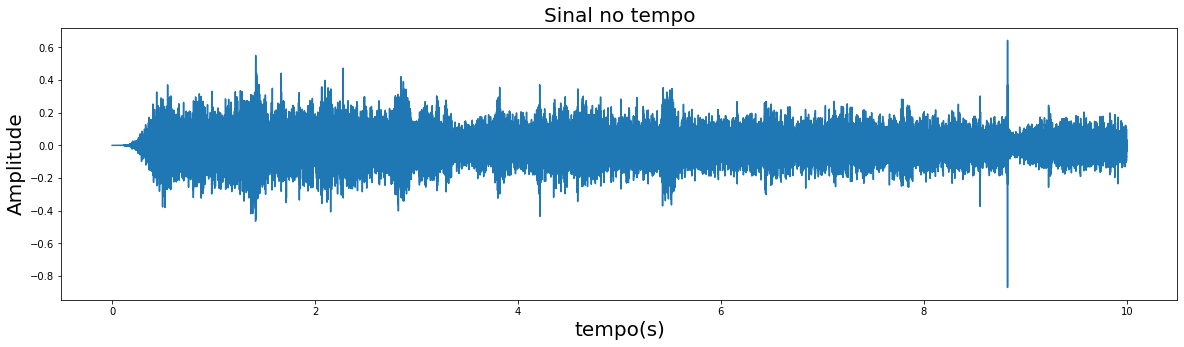

In [230]:
# Gerando gráfico do sinal bruto no domínio do tempo
g1 = plt.figure(figsize=(20,5))
plt.plot(t, signal)
plt.title('Sinal no tempo', fontsize=20)
plt.xlabel("tempo(s)", fontsize=20)
plt.ylabel("Amplitude", fontsize=20)


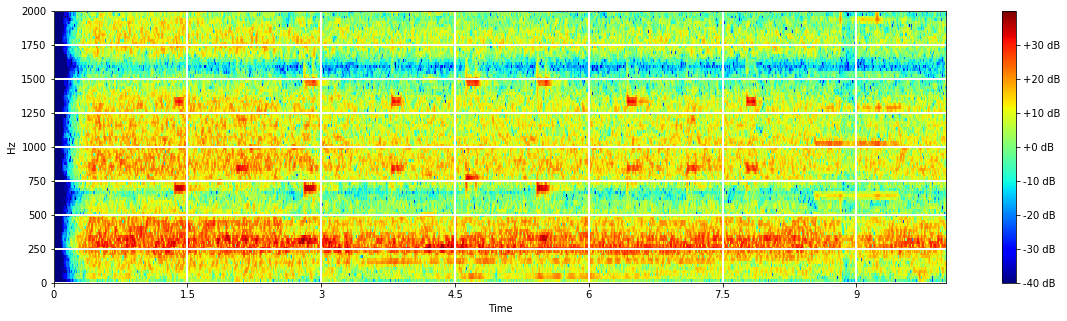

In [231]:
espectograma(signal, fs)

Já é possível observar as teclas digitadas sem utilizar os filtros porém vamos melhorar o sinal.

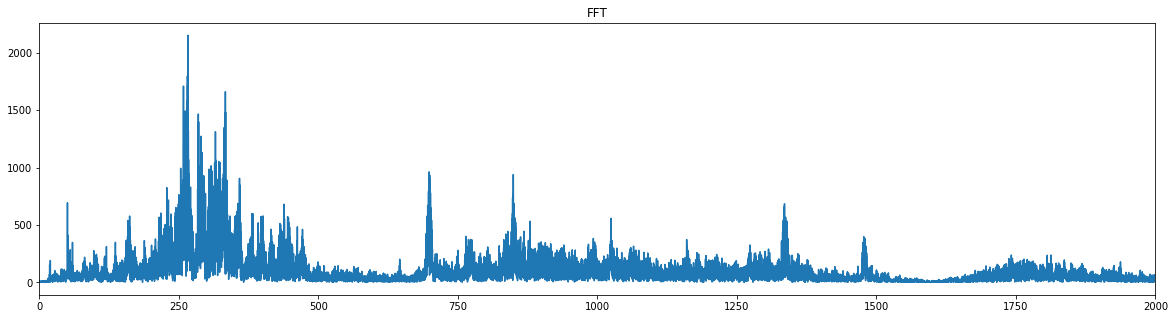

In [232]:
# Transformada domínio da frequência
datafft, freq = espectral_single(signal, fs)
# Plot da FFT
espectral_plot(datafft, freq)


### Aplicação do Filtro IIR Anti-aliasing do tipo 1, para que não ocorra o aliasing 


a ordem do filtro necessária é 9


(-40, 0)

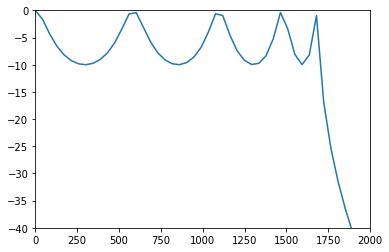

In [233]:
# construindo um filtro chebyschev tipo 1 passa baixa 
# frequencia de amostragem 48000 Hz
# largura da faixa de transição 200 Hz

#determinando os parametros

Wp = 1700  #frequencia minima banda de transicao
Ws = 1900 #frequencia maxima banda de transicao
Rp = 10 #atenuacao maxima banda de passagem
Rs = 40 #atenuacao minima banda de rejeicao

#determinando a ordem do filtro chebyschev do tipo 1

ord,Wn = ss.cheb1ord(Wp,Ws,Rp,Rs,fs=fs)
print('a ordem do filtro necessária é ' + str(ord))

#projetando o filtro

b,a = ss.cheby1(ord,Rp,Wn,'low',fs=fs)
freq,abss = ss.freqz(b,a,fs=fs)

Db = 20*np.log10(abs(abss))
plt.plot(freq,Db)
plt.xlim([0,2000])
plt.ylim([-40,0])

Text(0, 0.5, 'Magnitude')

/home/caiomorozini/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


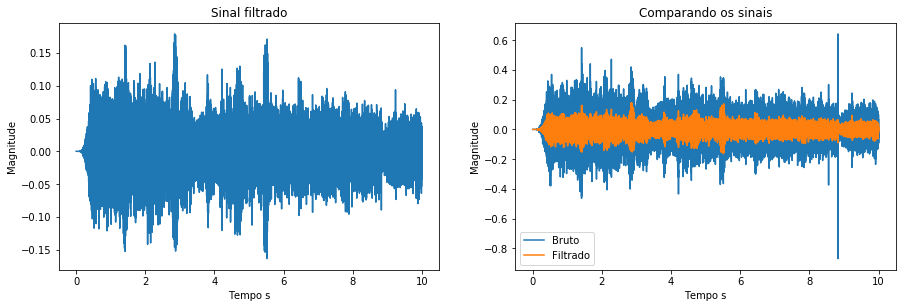

In [234]:
#filtrando o sinal

filtered = ss.lfilter(b,a,signal)
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(t,filtered)
plt.title('Sinal filtrado')
plt.xlabel('Tempo s')
plt.ylabel('Magnitude')

plt.subplot(222)
plt.plot(t,signal)
plt.plot(t,filtered)
plt.legend(['Bruto','Filtrado'])
plt.title('Comparando os sinais')
plt.xlabel('Tempo s')
plt.ylabel('Magnitude')

(0, 3000)

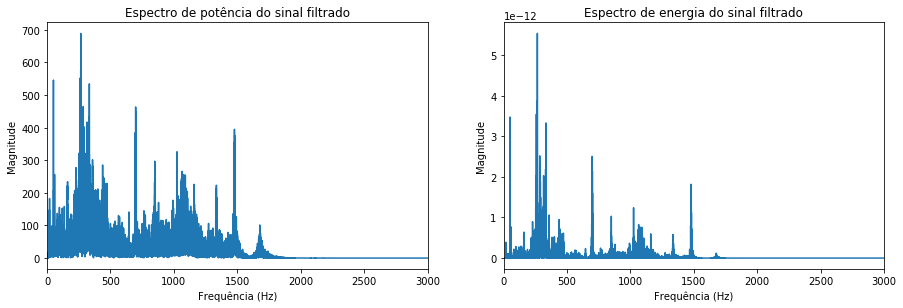

In [235]:
spec = np.fft.fft(filtered)
mag = np.absolute(spec)
mag = mag/mag.shape[0]
# Fazendo o espectro de energia
e_spec = mag**2/mag.shape[0]
frq = np.arange(0,fs,fs/mag.shape[0])

plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(frq,abs(spec))
plt.title('Espectro de potência do sinal filtrado')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.xlim([0,3000])

plt.subplot(222)
plt.plot(frq,e_spec)
plt.title('Espectro de energia do sinal filtrado')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.xlim([0,3000])

## Downsampling
    fs mínima será o dobro da frequência máxima (2000 Hz), ou seja, 4000 Hz.
---


valor de k: 11
a freq da reamostragem: 4009.09Hz 


(0, 2004.5454545454545)

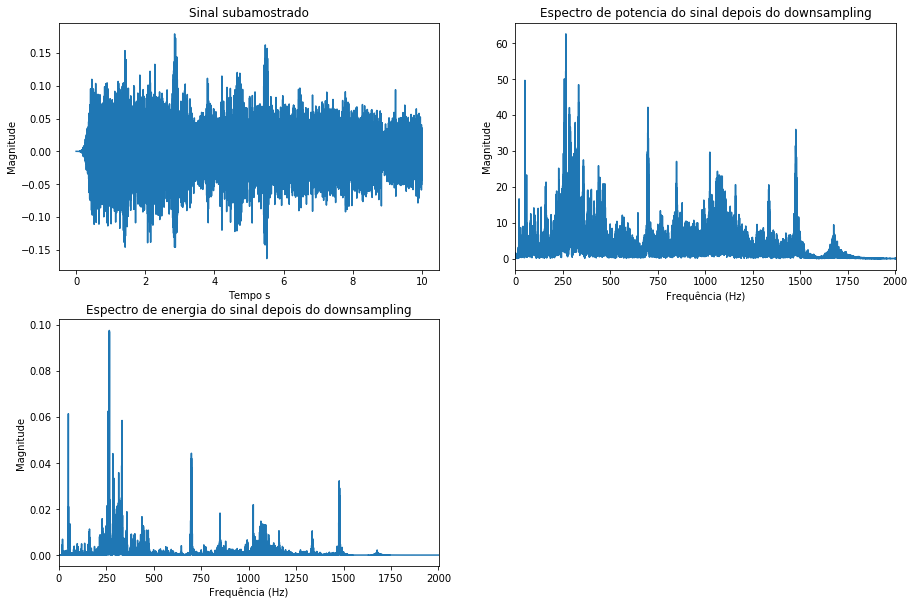

In [236]:
k = int(np.floor(fs/4000))
print(f'valor de k: {k}')

t_downsample = t[::k]
fsnew = 1/(t_downsample[1]-t_downsample[0])
signal_downsample = filtered[::k]

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(t_downsample,signal_downsample)
plt.title('Sinal subamostrado')
plt.xlabel('Tempo s')
plt.ylabel('Magnitude')

print(f'a freq da reamostragem: {fsnew:.2f}Hz ')

# espectro fft e espectro de energia do sinal que foi subamostrado

fft_downsample = np.fft.fft(signal_downsample)
fft_downsample = np.absolute(fft_downsample)

mag = fft_downsample/fft_downsample.shape[0]

# fazendo o espectro de energia
e_spec = fft_downsample**2/fft_downsample.shape[0]
freq_downsample = np.arange(0,fsnew,fsnew/mag.shape[0])

plt.subplot(222)
plt.plot(freq_downsample, fft_downsample)
plt.title('Espectro de potencia do sinal depois do downsampling')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.xlim([0,fsnew/2])

plt.subplot(223)

plt.plot(freq_downsample, e_spec)
plt.title('Espectro de energia do sinal depois do downsampling')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.xlim([0,fsnew/2])

4009.090909090909

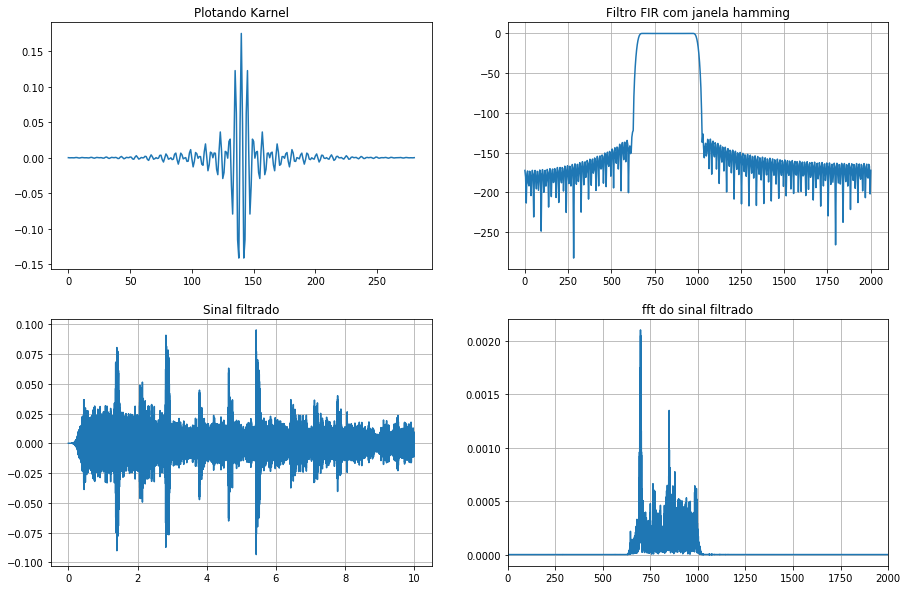

In [237]:
order = 281

#projetando o karnel para filtro passa banda
h_fir1 = ss.firwin(order,[650, 1000],window='hamming',fs=fsnew,pass_zero='bandpass')

#calculando a resposta do filtro em frequencia
freq_fir1, abss_fir1 = ss.freqz(h_fir1,fs=fsnew) 
Db_fir1 = 20*np.log(abs(abss_fir1))
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(h_fir1)
plt.title('Plotando Karnel')
plt.subplot(222)
plt.plot(freq_fir1,Db_fir1)
plt.title('Filtro FIR com janela hamming')
plt.grid('on')

#plotando o sinal antes e depois
filtered_fir1 = np.convolve(h_fir1,signal_downsample,mode='same') #fazendo a filtragem do sinal fazendo a convolução
t = np.arange(filtered_fir1.size)/fsnew
plt.subplot(223)
plt.plot(t,filtered_fir1)
plt.title('Sinal filtrado')
plt.grid('on')

#fft do sinal filtrado
filteredfft_fir1 = abs(2*np.fft.fft(filtered_fir1)/filtered_fir1.shape[0])
freq_fir1 = np.linspace(0,fsnew-1/fsnew,filteredfft_fir1.shape[0])
plt.subplot(224)
plt.plot(freq_fir1,filteredfft_fir1)
plt.title('fft do sinal filtrado')
plt.xlim([0,2000])
plt.grid('on')
fsnew

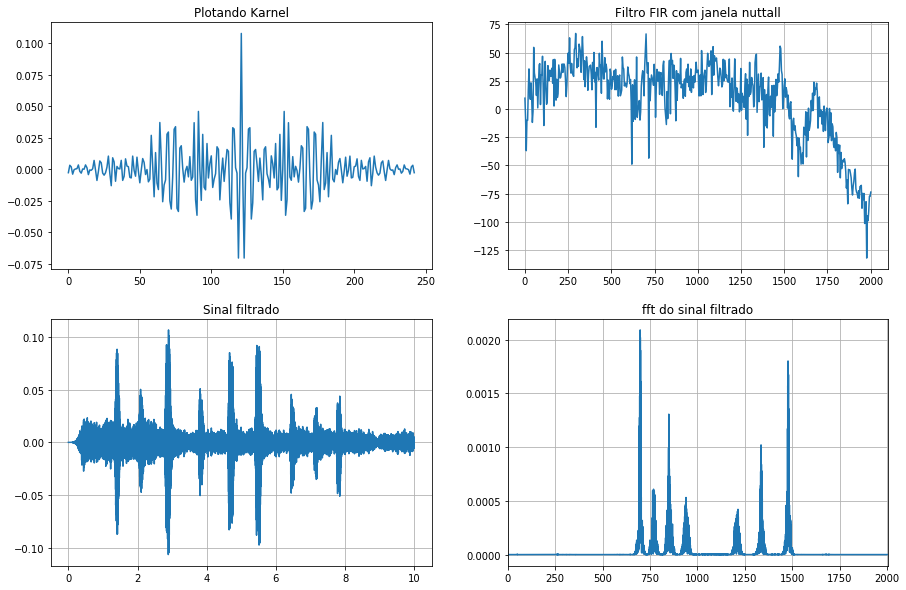

In [241]:
lista = [
    694,700, 
    767,773, 
    849, 855, 
    938, 944, 
    1206, 1212, 
    1333, 1339, 
    1474, 1480
    ]
order = 243

h_fir2 = ss.firwin(order,lista ,window='hamming',fs=fsnew, pass_zero='bandpass')
freq_fir2, abss_fir2 = ss.freqz(signal_downsample,fs=fsnew) 
Db_fir2 = 20*np.log(abs(abss_fir2))

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(h_fir2)
plt.title('Plotando Karnel')
plt.subplot(222)
plt.plot(freq_fir2,Db_fir2)
plt.title('Filtro FIR com janela nuttall')
plt.grid('on')


#plotando o sinal antes e depois
filtered_fir2 = np.convolve(h_fir2,signal_downsample,mode='same') #fazendo a filtragem do sinal fazendo a convolução
plt.subplot(223)
plt.plot(t,filtered_fir2)
plt.title('Sinal filtrado')
plt.grid('on')

#fft do sinal filtrado
filteredfft_fir2 = abs(2*np.fft.fft(filtered_fir2)/filtered_fir2.shape[0])
freq_fir2 = np.linspace(0,fsnew-1/fsnew,filteredfft_fir2.shape[0])
plt.subplot(224)
plt.plot(freq_fir2,filteredfft_fir2)
plt.title('fft do sinal filtrado')
plt.xlim([0,fsnew/2])
plt.grid('on')

(500, 1600)

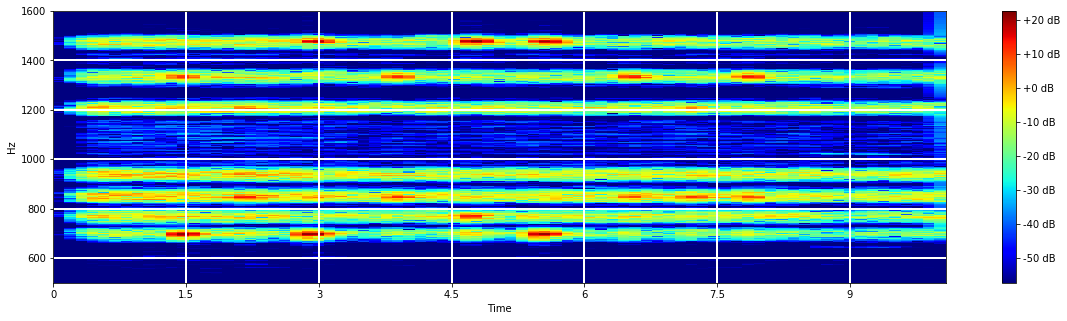

In [240]:
espectograma(filtered_fir2, fsnew)
plt.ylim([500,1600])

ID|TEMPO(s)|FMIN(Hz)|FMAX(Hz)|TECLA
---|---|---|---|---
1|1.5|700|1300|2
2|2.2|850|1200|7
3|3|700|1500|3
4|4.0|850|1330|8
5|4.7|760|1500|6
6|5.7|700|1500|3
7|6.3|850|1330|8
8|6.8|850|1200|7
9|7.3|850|1330|8